In [ ]:
!pip3 install keras==2.1.0

In [ ]:
#####################################################################
#####################################################################
###### This is tensorflow 1.15.2 and keras 2.1.0 implemenation ######
#####################################################################
#####################################################################

%tensorflow_version 1.x
import tensorflow as tf
import keras as k
print(tf.test.gpu_device_name())
print('tensorflow = ', tf.__version__) 
print('keras = ', k.__version__)

import os, datetime, sys 
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from zipfile import ZipFile
from tqdm import tqdm
import warnings 
warnings.filterwarnings("ignore")
import random
import cv2
from sklearn.model_selection import KFold
from imgaug import augmenters as ia
import glob, sys, json, urllib
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense, Flatten, Concatenate, Input, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, DenseNet121
from sklearn.model_selection import train_test_split
import multiprocessing as mp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

TensorFlow 1.x selected.


Using TensorFlow backend.


/device:GPU:0
tensorflow =  1.15.2
keras =  2.1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


While training I was first reading the images from the drive it was causing "I/O ERROR" or sometimes "DRIVE TIME OUT ERROR" and it was too slow. So, I created zip files of images_triplet folder google created 7 zip files each of size 2GB, I stored these zip files on google drive Now I am just unzipping each zip into the colab's disk. I do not need to read the images from drive anymore it saved lots of time of training.

In [ ]:
%%time
!unzip -qq '/content/drive/MyDrive/fashion_data/triplet/images_triplet1.zip' 
!unzip -qq '/content/drive/MyDrive/fashion_data/triplet/images_triplet2.zip'
!unzip -qq '/content/drive/MyDrive/fashion_data/triplet/images_triplet3.zip'
!unzip -qq '/content/drive/MyDrive/fashion_data/triplet/images_triplet4.zip'
!unzip -qq '/content/drive/MyDrive/fashion_data/triplet/images_triplet5.zip'
!unzip -qq '/content/drive/MyDrive/fashion_data/triplet/images_triplet6.zip'
!unzip -qq '/content/drive/MyDrive/fashion_data/triplet/images_triplet7.zip'

CPU times: user 3.6 s, sys: 850 ms, total: 4.45 s
Wall time: 10min 55s


In [ ]:
meta_df_new = pd.read_csv('/content/drive/MyDrive/fashion_data/triplet/final_triplet.csv') ### load final_triplet.csv file
image_path = 'images_triplet/'
meta_df_new.drop(columns = ['level_0', 'index'], inplace = True)
meta_df_new.head()

,type,category,street_photo_id,product_id,width,top,height,left,shop_photo_id,street_photo_url,shop_photo_url,is_selected
0,train,dresses,10222,28493,311,249,594,282,55399,http://media1.modcloth.com/community_outfit_im...,http://productshots0.modcloth.net/productshots...,1
1,train,skirts,10878,3733,167,221,190,154,97361,http://media1.modcloth.com/community_outfit_im...,http://productshots2.modcloth.net/productshots...,1
2,train,dresses,10585,47823,840,970,1415,665,40225,http://media1.modcloth.com/community_outfit_im...,http://productshots0.modcloth.net/productshots...,1
3,test,footwear,9760,24120,80,977,131,290,23712,http://media1.modcloth.com/community_outfit_im...,http://productshots2.modcloth.net/productshots...,1
4,train,dresses,1691,25753,534,1023,1040,869,58474,http://media1.modcloth.com/community_outfit_im...,http://productshots0.modcloth.net/productshots...,1


We are here creating three columns anchor_path (path to the anchor image), pos_path (path to the positive image), neg_path(path to the negative image), To get the neg_path of some rowX I am first creating temp_df this df contains all the rows whose category is same as rowX then from temp_df I am taking pos path of any row and setting it as neg_path of rowX. The categories such as hats, belts, eywear have very few images I chose to remove them.

An anchor image can have multiple categories in it at a time we need to focus on single category to do that they have provided top , left, height, width, using these I have created two points (x1, y1) [Top Left] and (x2, y2) [bottom] we will crop the image using these two points and send this cropped image along with its positive and negative image to the Triplet Network.

In [ ]:
meta_df_new = meta_df_new[~meta_df_new['category'].isin(['hats', 'belts', 'eyewear'])] ## only 100 to 200 images presents so remove these categories
categories = set(meta_df_new.category.values)

In [ ]:
%%time
meta_df_new['anchor_path'] = image_path + meta_df_new['street_photo_id'].apply(lambda x : str(x)) + '.jpg'
meta_df_new['pos_path'] = image_path + meta_df_new['shop_photo_id'].apply(lambda x :str(x)) + '.jpg'

meta_df_new['x1'] = meta_df_new['left']
meta_df_new['y1'] = meta_df_new['top']
meta_df_new['x2'] = meta_df_new['left'] + meta_df_new['width']
meta_df_new['y2'] = meta_df_new['top'] + meta_df_new['height']

neg_path = []
for i in range(len(meta_df_new)) :
    cat = meta_df_new.iloc[i]['category']
    temp_df = meta_df_new[meta_df_new['category'] == cat]
    temp_df = shuffle(temp_df)
    ind = np.random.randint(0, len(temp_df))
    neg_photo_id = str(temp_df.iloc[ind]['shop_photo_id']) + '.jpg'
    neg_path.append(image_path + neg_photo_id)
meta_df_new['neg_path'] = neg_path

CPU times: user 3min 1s, sys: 1.17 s, total: 3min 2s
Wall time: 3min 2s


In [ ]:
meta_df_new.to_csv('/content/drive/MyDrive/fashion_data/triplet/triplet_noncorrupt.csv', index = False) ## save processed file to avoid redoing

In [ ]:
import pandas as pd
meta_df_new = pd.read_csv('/content/drive/MyDrive/fashion_data/triplet/triplet_noncorrupt.csv') ## reading the saved file
meta_df_new.head()

,Unnamed: 0,type,category,street_photo_id,product_id,width,top,height,left,shop_photo_id,street_photo_url,shop_photo_url,is_selected,is_corrupt,anchor_path,pos_path,x1,y1,x2,y2,neg_path
0,0,train,skirts,10878,3733,167,221,190,154,97361,http://media1.modcloth.com/community_outfit_im...,http://productshots2.modcloth.net/productshots...,1,0,images_triplet/10878.jpg,images_triplet/97361.jpg,154,221,321,411,images_triplet/63337.jpg
1,1,train,dresses,10585,47823,840,970,1415,665,40225,http://media1.modcloth.com/community_outfit_im...,http://productshots0.modcloth.net/productshots...,1,0,images_triplet/10585.jpg,images_triplet/40225.jpg,665,970,1505,2385,images_triplet/52805.jpg
2,2,test,footwear,9760,24120,80,977,131,290,23712,http://media1.modcloth.com/community_outfit_im...,http://productshots2.modcloth.net/productshots...,1,0,images_triplet/9760.jpg,images_triplet/23712.jpg,290,977,370,1108,images_triplet/22346.jpg
3,3,train,dresses,1691,25753,534,1023,1040,869,58474,http://media1.modcloth.com/community_outfit_im...,http://productshots0.modcloth.net/productshots...,1,0,images_triplet/1691.jpg,images_triplet/58474.jpg,869,1023,1403,2063,images_triplet/36594.jpg
4,4,train,dresses,7373,38264,966,735,1142,687,79982,http://media1.modcloth.com/community_outfit_im...,http://productshots1.modcloth.net/productshots...,1,0,images_triplet/7373.jpg,images_triplet/79982.jpg,687,735,1653,1877,images_triplet/97325.jpg


In [ ]:
meta_df_new = pd.read_csv('/content/drive/MyDrive/fashion_data/triplet/triplet_noncorrupt.csv') ## reading the saved file
image_path = 'images_triplet/'
train_df, val_df = train_test_split(meta_df_new, test_size = 0.25, random_state = 33) ## train test split

###Data Pipeline

In [ ]:
EMBED_SIZE = 100         ### Change Later
IMAGE_SIZE = 256
BATCH_SIZE = 24
MARGIN = 1
LR = 0.01 
#ALPHA = 5e-5
#TAU = (1 / (3 * EMBED_SIZE))

class Dataset :
    def __init__(self, df, aug_flag = False) :
        self.data = df
        self.aug_flag = aug_flag
        self.aug1 = ia.Dropout(p=0.01)
        self.aug2 = ia.GaussianBlur(sigma=(0.0, 3.0))
        self.aug3 = ia.flip.Fliplr(0.8)
        self.aug4 = ia.flip.Flipud(0.8)
        self.aug5 = ia.Alpha((0.0, 1.0), ia.AllChannelsHistogramEqualization())
        
    def __getitem__(self, i) :
        row = self.data.iloc[i]
        anchor_path = row['anchor_path']
        pos_path = row['pos_path']
        neg_path = row['neg_path']   ## change after testing pos to neg
        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']

        anchor_img = cv2.imread(anchor_path)
        anchor_img = cv2.cvtColor(src = anchor_img, code = cv2.COLOR_BGR2RGB)

        pos_img = cv2.imread(pos_path)
        pos_img = cv2.cvtColor(src = pos_img, code = cv2.COLOR_BGR2RGB)

        neg_img = cv2.imread(neg_path)
        neg_img = cv2.cvtColor(src = neg_img, code = cv2.COLOR_BGR2RGB)

        anchor_img = anchor_img[y1:y2 + 1, x1:x2 + 1, :] ## crop image using bounding 
        anchor_img = cv2.resize(anchor_img, (IMAGE_SIZE, IMAGE_SIZE), cv2.INTER_NEAREST) ## resize it
        pos_img = cv2.resize(pos_img, (IMAGE_SIZE, IMAGE_SIZE), cv2.INTER_NEAREST)
        neg_img = cv2.resize(neg_img, (IMAGE_SIZE, IMAGE_SIZE), cv2.INTER_NEAREST)

        if self.aug_flag :
            a = np.random.uniform()
            if a < 0.4 :
                b = np.random.uniform()
                if b < 0.2 :
                    anchor_img = self.aug1.augment_image(anchor_img)
                    pos_img = self.aug1.augment_image(pos_img)
                    neg_img = self.aug1.augment_image(neg_img)

                elif b < 0.4:
                    anchor_img = self.aug2.augment_image(anchor_img)
                    pos_img = self.aug2.augment_image(pos_img)
                    neg_img = self.aug2.augment_image(neg_img)

                elif b < 0.6:
                    anchor_img = self.aug3.augment_image(anchor_img)
                    pos_img = self.aug3.augment_image(pos_img)
                    neg_img = self.aug3.augment_image(neg_img)

                elif b < 0.8:
                    anchor_img = self.aug4.augment_image(anchor_img)
                    pos_img = self.aug4.augment_image(pos_img)
                    neg_img = self.aug4.augment_image(neg_img)
                
                elif b < 1 :
                    anchor_img = self.aug5.augment_image(anchor_img)
                    pos_img = self.aug5.augment_image(pos_img)
                    neg_img = self.aug5.augment_image(neg_img)

        #print(anchor_img.shape, pos_img.shape, neg_img.shape)
        return anchor_img.astype('float32'), pos_img.astype('float32'), neg_img.astype('float32'), row['category'], row['pos_path'], row['anchor_path']

    def __len__(self):
        return len(self.data)

class Dataloader(tf.keras.utils.Sequence) :
    def __init__(self, dataset, batch_size = 2, shuffle = False) :
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset))
        self.shuffle = shuffle
    
    def __getitem__(self, ind) :
        anchor_list = []
        pos_list = []
        neg_list = []
        for i in self.indexes[ind * self.batch_size : (ind + 1)*self.batch_size] :
            anchor, pos, neg, category, pos_path, anchor_path = self.dataset[i]
            anchor_list.append(anchor)
            pos_list.append(pos)
            neg_list.append(neg)
        
        anchor_array = np.stack(anchor_list, axis = 0)
        pos_array = np.stack(pos_list, axis = 0)
        neg_array = np.stack(neg_list, axis = 0)
        y = None                                                                                         
        return ([anchor_array, pos_array, neg_array], y)

    def __len__(self): ## Number of batches we can generate
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle :
            self.indexes = np.random.permutation(self.indexes)


In [ ]:

#sampler = RandomOverSampler()
#train_df_new, y = sampler.fit_resample(train_df, train_df.category.values)
#train_df_new = train_df  ## in case you want to try oversampling comment it when oversampling is used
#train_df_new = pd.DataFrame(train_df_new, columns = train_df.columns)
#train_df_new = shuffle(train_df_new)

#train_df = train_df[(train_df.shop_photo_id.isin(id_list) & train_df.street_photo_id.isin(id_list))]
#val_df = val_df[(val_df.shop_photo_id.isin(id_list) & val_df.street_photo_id.isin(id_list))]

train_dataset = Dataset(train_df, aug_flag = True)
valid_dataset = Dataset(val_df)  

train_gen = Dataloader(train_dataset, BATCH_SIZE, shuffle = True)
valid_gen = Dataloader(valid_dataset, BATCH_SIZE, shuffle = True)


Lets have a look at some of the images that we are sending to the triplet network.

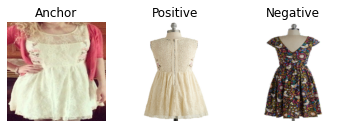

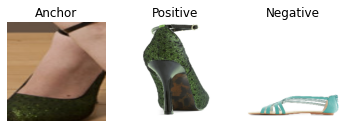

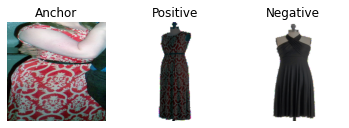

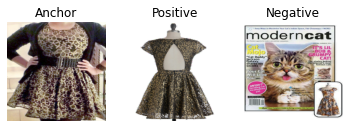

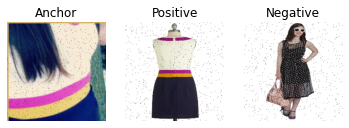

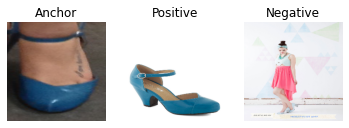

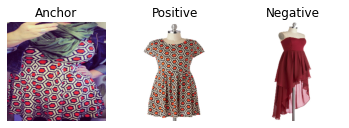

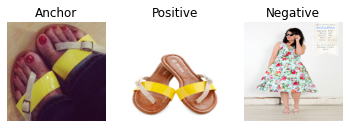

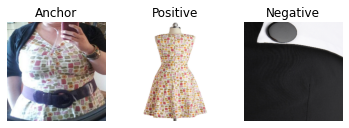

In [ ]:
ind = np.random.randint(0, len(train_gen))
image_set = train_gen[ind][0]
anchor = image_set[0]
pos = image_set[1] 
neg = image_set[2]

for i in range(BATCH_SIZE) :
    fig, ax = plt.subplots(1, 3)
    ax[0].set_title('Anchor')
    ax[0].imshow(anchor[i].astype(int))
    ax[0].axis('off')
    ax[1].set_title('Positive')
    ax[1].imshow(pos[i].astype(int))
    ax[1].axis('off')
    ax[2].set_title('Negative')
    ax[2].imshow(neg[i].astype(int))
    ax[2].axis('off')
    if i == 8 :
        break

###Build Model

In [ ]:
def triplet_loss(yactual, ypred) :
    ypred = tf.transpose(ypred, perm = [1, 0, 2])
    anchor, pos, neg = ypred[0], ypred[1], ypred[2]
    anchor_pos = tf.sqrt(tf.reduce_sum(tf.square(anchor - pos), axis = -1))
    anchor_neg = tf.sqrt(tf.reduce_sum(tf.square(anchor - neg), axis = -1))
    zeros = tf.constant(0, dtype = tf.float32)
    Ltriplet = tf.math.maximum(zeros, MARGIN + (anchor_pos - anchor_neg))   ### change after testing reminder
    return tf.reduce_mean(Ltriplet)

In [ ]:
class Triplet_Model(tf.keras.Model) :
    def __init__(self, embedding_size = 32) :
        super(Triplet_Model, self).__init__()
        self.embedding_size = embedding_size
        self.resnet_obj = ResNet50(include_top=False, weights='imagenet', pooling = 'max')
        for layer in self.resnet_obj.layers :
            layer.Trainable = True
        for layer in self.resnet_obj.layers[0 : len(self.resnet_obj.layers) - 40] :
            layer.Trainable = False
        self.dense1 = Dense(units = self.embedding_size)
        self.drop1 = Dropout(0.5)
        #self.Lambda = Lambda(lambda x : tf.keras.backend.l2_normalize(x,axis=1))

    def build(self, input_shape):
        super(Triplet_Model, self).build(input_shape)   

    def call(self, data) :
        anchor_img = data[0]
        pos_img = data[1]
        neg_img = data[2]

        anchor = self.resnet_obj(anchor_img) 
        neg = self.resnet_obj(neg_img)
        pos = self.resnet_obj(pos_img)

        anchor = self.drop1(anchor)
        neg = self.drop1(neg)
        pos = self.drop1(pos)

        anchor = self.dense1(anchor)
        neg = self.dense1(neg)
        pos = self.dense1(pos)

        anchor = tf.math.l2_normalize(anchor, axis = 1)
        neg = tf.math.l2_normalize(neg, axis = 1)
        pos = tf.math.l2_normalize(pos, axis = 1)

        out_array  = tf.TensorArray(dtype = tf.float32, size = 3)
        out_array = out_array.write(0, anchor)
        out_array = out_array.write(1, pos)
        out_array = out_array.write(2, neg)
        print(anchor.shape, neg.shape, pos.shape)
        return tf.transpose(out_array.stack(), perm = [1, 0, 2])

###Training

In [ ]:
%%time
#for layer in resnet_obj.layers[0: len(resnet_obj.layers) - 35] : # Train only last 35 layers
#    layer.trainable = False
    
LR1 = 0.0001
tf.keras.backend.clear_session()
#k.backend.clear_session()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/fashion_data/triplet/triplet_weights_latest11.hd5', \
                                                     monitor = 'val_loss', save_weights_only = True, save_best_only = True)

model = Triplet_Model(embedding_size = EMBED_SIZE)
model.compile(optimizer = tf.keras.optimizers.Adam(lr = LR1), loss = triplet_loss)
model.fit_generator(train_gen, epochs = 10, steps_per_epoch = 150,  validation_data = valid_gen, validation_steps = 70, callbacks = [model_checkpoint])

Epoch 1/10
(?, 100) (?, 100) (?, 100)
150/150 [==============================] - 479s 3s/step - loss: 0.6870 - val_loss: 0.5488
Epoch 2/10
150/150 [==============================] - 447s 3s/step - loss: 0.5803 - val_loss: 0.5064
Epoch 3/10
150/150 [==============================] - 445s 3s/step - loss: 0.5646 - val_loss: 0.5193
Epoch 4/10
150/150 [==============================] - 454s 3s/step - loss: 0.5009 - val_loss: 0.4693
Epoch 5/10
150/150 [==============================] - 448s 3s/step - loss: 0.4910 - val_loss: 0.4393
Epoch 6/10
150/150 [==============================] - 449s 3s/step - loss: 0.4655 - val_loss: 0.4340
Epoch 7/10
150/150 [==============================] - 449s 3s/step - loss: 0.4417 - val_loss: 0.4347
Epoch 8/10
150/150 [==============================] - 448s 3s/step - loss: 0.4200 - val_loss: 0.4127
Epoch 9/10
150/150 [==============================] - 447s 3s/step - loss: 0.4404 - val_loss: 0.3986
Epoch 10/10
150/150 [==============================] - 448s 3s/s

In [ ]:
%%time
tf.keras.backend.clear_session()
model = Triplet_Model(embedding_size = EMBED_SIZE)
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.00005), loss = triplet_loss)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/fashion_data/triplet/triplet_weights_latest22.hd5', \
                                                    monitor = 'val_loss', save_weights_only = True, save_best_only = True)
model.load_weights('/content/drive/MyDrive/fashion_data/triplet/triplet_weights_latest11.hd5')
model.fit_generator(train_gen, epochs = 20, steps_per_epoch = 150,  validation_data = valid_gen, validation_steps = 70, callbacks = [model_checkpoint])

Epoch 1/20
(?, 100) (?, 100) (?, 100)
150/150 [==============================] - 1154s 8s/step - loss: 0.4139 - val_loss: 0.4052
Epoch 2/20
150/150 [==============================] - 535s 4s/step - loss: 0.4057 - val_loss: 0.3622
Epoch 3/20
150/150 [==============================] - 534s 4s/step - loss: 0.4089 - val_loss: 0.3925
Epoch 4/20
150/150 [==============================] - 527s 4s/step - loss: 0.4116 - val_loss: 0.3727
Epoch 5/20
150/150 [==============================] - 518s 3s/step - loss: 0.3959 - val_loss: 0.3869
Epoch 6/20
150/150 [==============================] - 520s 3s/step - loss: 0.3906 - val_loss: 0.3558
Epoch 7/20
150/150 [==============================] - 521s 3s/step - loss: 0.3963 - val_loss: 0.3594
Epoch 8/20
150/150 [==============================] - 522s 3s/step - loss: 0.3728 - val_loss: 0.3488
Epoch 9/20
150/150 [==============================] - 515s 3s/step - loss: 0.3792 - val_loss: 0.3556
Epoch 10/20
150/150 [==============================] - 519s 3s/

### Performace Metric 
To measure the performance of triplet network we are using 'Accuracy'. We are defining 'Accuracy' as [hits / (hits + misses)]. For a given image We say we have 'hit' if its positive image id is in top k image ids we got using cosine similarity else we say we have a 'miss'. We will take [24 * 100] images and calculate the Accuracy.

In [ ]:
tf.keras.backend.clear_session()
model = Triplet_Model(embedding_size = EMBED_SIZE)
model.load_weights('/content/drive/MyDrive/fashion_data/triplet/triplet_weights_latest22.hd5')

In [ ]:
%%time
category_list = []
anchor_embedding_list = []
shop_id_list = []
shop_embedding_list = []

for i in tqdm(range(100)) :
    pos_list = []
    anchor_list = []
    for j in range(i * BATCH_SIZE, (i + 1) * BATCH_SIZE) :
        anchor, pos, neg, cat, path_instance, anchor_path = valid_dataset[j]
        category_list.append(cat)
        pos_list.append(pos)
        anchor_list.append(anchor)
        shop_id_list.append(path_instance.split('/')[1])
    pos_array = np.stack(pos_list, axis = 0)
    anchor_array = np.stack(anchor_list, axis = 0)
    x = model.predict([pos_array, pos_array, pos_array])
    x = np.transpose(x, axes = [1, 0, 2])[1]
    shop_embedding_list.extend(x)
    y = model.predict([anchor_array, anchor_array, anchor_array])
    y = np.transpose(y, axes = [1, 0, 2])[1]
    anchor_embedding_list.extend(y)

metric_df = pd.DataFrame({'category' : category_list, 'shop_embeddings' : shop_embedding_list, 'anchor_embeddings' : anchor_embedding_list, 'shop_id' : shop_id_list})

100%|██████████| 100/100 [04:19<00:00,  2.60s/it]

CPU times: user 4min 25s, sys: 18.5 s, total: 4min 43s
Wall time: 4min 19s


In [ ]:
%%time
topk = 15
hits = 0
misses = 0

for i, row in metric_df.iterrows() :
    v = row['anchor_embeddings']
    cat = row['category']
    temp_df = metric_df[metric_df['category'] == cat]
    similarity = temp_df['shop_embeddings'].apply(lambda x: np.dot(v,x)/(np.linalg.norm(v)*np.linalg.norm(x)))
    nearestItemsIndex = similarity.sort_values(ascending=False).iloc[0:topk]
    nearestItems = temp_df.loc[nearestItemsIndex.index][['category', 'shop_id']]
    if row['shop_id'] in nearestItems['shop_id'].values :
        hits +=1 
    else : 
        misses += 1

acc = hits / (hits + misses)
print('Accuracy = ', acc, '\n')

Accuracy =  0.44916666666666666
CPU times: user 32.3 s, sys: 1.03 s, total: 33.4 s
Wall time: 32.3 s


###Results

In [ ]:
%%time

path_list = []
embedding_list = []
shop_photo_list = list(set(meta_df_new['shop_photo_id']))
category_list = [meta_df_new[meta_df_new['shop_photo_id'] == x]['category'].iloc[0] for x in shop_photo_list]

for i in tqdm(range(len(shop_photo_list) // BATCH_SIZE)) :
    start = i * BATCH_SIZE
    end = (i + 1) * BATCH_SIZE
    pos_list = []
    for j in range(start, end) :
        path = image_path + str(shop_photo_list[j]) + '.jpg'
        pos_img = cv2.imread(path)
        pos_img = cv2.cvtColor(src = pos_img, code = cv2.COLOR_BGR2RGB)
        pos_img = cv2.resize(src = pos_img, dsize = (IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_NEAREST)
        pos_list.append(pos_img.astype(float))
    pos_array = np.stack(pos_list, axis = 0)
    x = model.predict([pos_array, pos_array, pos_array])
    x = np.transpose(x, axes = [1, 0, 2])
    embedding_list.extend(x[1])

embed_df = pd.DataFrame({'category' : category_list[0 : len(embedding_list)], 'shop_embeddings' : embedding_list, 'shop_photo_id' : shop_photo_list[0 : len(embedding_list)]})

100%|██████████| 803/803 [08:02<00:00,  1.66it/s]

CPU times: user 7min 54s, sys: 1min 5s, total: 9min
Wall time: 8min 14s


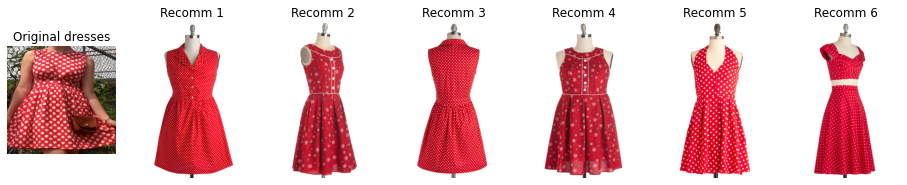

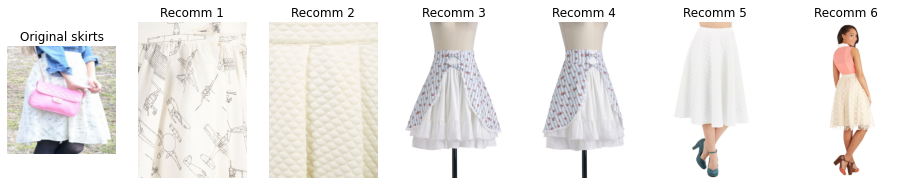

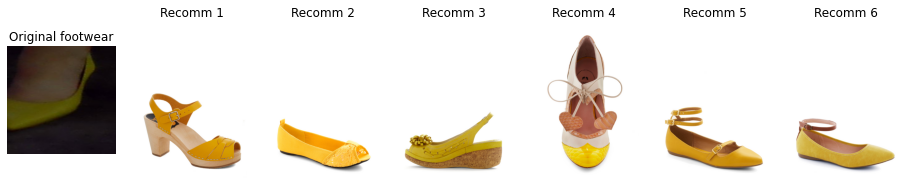

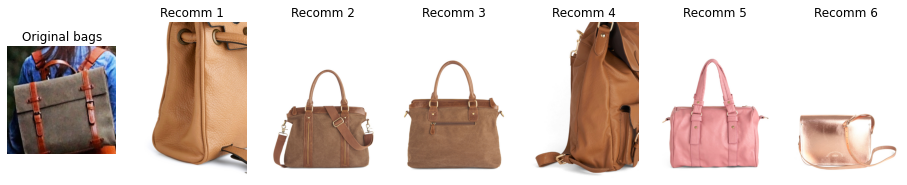

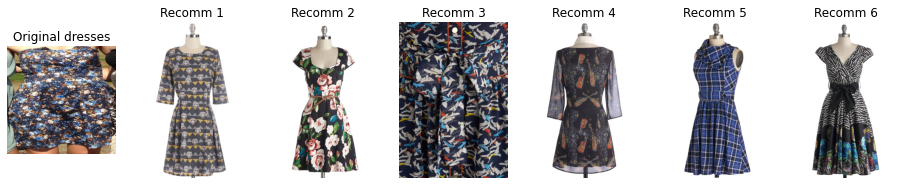

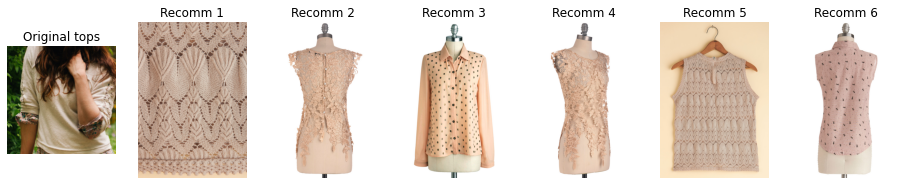

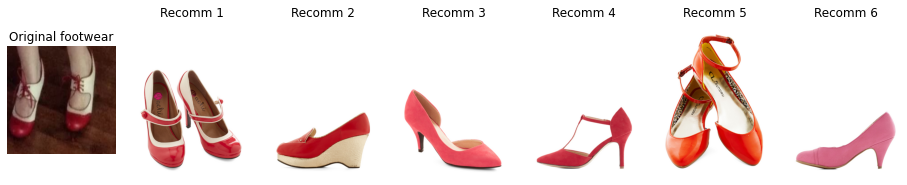

In [ ]:
topk = 6

for i in range(7) :
    ind = np.random.randint(0, len(valid_dataset))
    anchor, pos, neg, cat, pos_path, anchor_path = valid_dataset[ind]
    fig, ax = plt.subplots(1, topk + 1, figsize = (16, 10))
    ax[0].imshow(anchor.astype(int))
    ax[0].axis('off')
    ax[0].set_title('Original {}'.format(cat))
    anchor = anchor.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    v = model.predict([anchor, anchor, anchor])
    v = np.transpose(v, axes = [1, 0, 2])[1]
    v = np.squeeze(v)
    temp_df = embed_df[embed_df['category'] == cat]
    similarity = temp_df['shop_embeddings'].apply(lambda x: np.dot(v,x)/(np.linalg.norm(v)*np.linalg.norm(x)))
    nearestItemsIndex = similarity.sort_values(ascending=False).iloc[0:topk]
    nearestItems = temp_df.loc[nearestItemsIndex.index][['category', 'shop_photo_id']]

    for j, shop_id in enumerate(nearestItems['shop_photo_id'].values) :
        path = image_path + str(shop_id) + '.jpg'
        img = cv2.imread(path)
        img = cv2.cvtColor(img, code = cv2.COLOR_BGR2RGB)
        ax[j + 1].imshow(img)
        ax[j + 1].axis('off')
        ax[j + 1].set_title('Recomm {}'.format(j + 1))

In [ ]:
embed_df.to_csv('/content/drive/MyDrive/fashion_data/triplet/triplet_embeddings_new.csv')  ## Saving embeddings to drive

In [ ]:
## Loss tried but could not tune the model

def triplet_loss_modified(yactual, ypred) :
    anchor, pos, neg = ypred[0], ypred[1], ypred[2]
    anchor_pos = tf.reduce_sum(tf.square(anchor - pos), axis = -1)
    anchor_neg = tf.reduce_sum(tf.square(anchor - neg), axis = -1)
    zeros = tf.constant(0, dtype = tf.float32)
    Ltriplet = tf.math.maximum(zeros, MARGIN + (anchor_pos - anchor_neg))
    Lembed = tf.reduce_sum(tf.square(anchor), axis = -1) + \
             tf.reduce_sum(tf.square(pos), axis = -1) + \
             tf.reduce_sum(tf.square(neg), axis = -1)
    #print(Ltriplet.shape, anchor_pos.shape, anchor_neg.shape, Lembed.shape)
    Lembed = Lembed * TAU  ### Lembed term is introduced to make sure embeddings remains inside the circle of radius = margin
    return Ltriplet + (ALPHA * Lembed)